# Network Anomaly Detection Model Training
This notebook demonstrates the full pipeline for training an anomaly detection model on network data. Each step is separated for clarity.

### 1. Import Required Libraries

In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../Model')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [3]:
import os
import torch
import numpy as np
import random
from torch.utils.data import DataLoader, random_split
from model import AnomalyDetector
from utils.data_loader import NetworkDataset

### 2. Set Seeds for Reproducibility

In [7]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### 3. Device Configuration (CPU/GPU)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


### 4. Set Hyperparameters and Data Paths

In [9]:
csv_file = '../Data/processed/NetworkData.csv'  # Adjust path if needed
input_dim = 10  # Set according to your data features
batch_size = 64
epochs = 50
lr = 1e-3
val_split = 0.2
patience = 5  # Early stopping patience

### 5. Load Dataset and Create DataLoaders

In [10]:
dataset = NetworkDataset(csv_file)
val_size = int(len(dataset) * val_split)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print(f'Train size: {train_size}, Validation size: {val_size}')

Train size: 800000, Validation size: 200000


### 6. Initialize Model, Loss Function, and Optimizer

In [11]:
model = AnomalyDetector(input_dim).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### 7. Training Loop with Early Stopping and Checkpointing

In [ ]:
best_val_loss = float('inf')
epochs_no_improve = 0
#os.makedirs('saved_models', exist_ok=True)

try:
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for features, _ in train_loader:
            features = features.to(device)
            output = model(features)
            loss = criterion(output, features)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)

        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for features, _ in val_loader:
                features = features.to(device)
                output = model(features)
                loss = criterion(output, features)
                val_losses.append(loss.item())
        avg_val_loss = np.mean(val_losses)

        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        # Early stopping and checkpointing
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), '../Model/saved_models/anomaly_detector.pth')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print('Early stopping triggered.')
                break
except KeyboardInterrupt:
    print('Training interrupted. Saving current model...')
    torch.save(model.state_dict(), '../Model/saved_models/anomaly_detector_interrupt.pth')

Epoch 1, Train Loss: 0.0108, Val Loss: 0.0002
Epoch 2, Train Loss: 0.0001, Val Loss: 0.0000
Epoch 3, Train Loss: 0.0001, Val Loss: 0.0001
Epoch 4, Train Loss: 0.0001, Val Loss: 0.0002
Epoch 5, Train Loss: 0.0001, Val Loss: 0.0000
Epoch 6, Train Loss: 0.0001, Val Loss: 0.0001
Epoch 7, Train Loss: 0.0001, Val Loss: 0.0001
Epoch 8, Train Loss: 0.0001, Val Loss: 0.0003
Epoch 9, Train Loss: 0.0001, Val Loss: 0.0001
Epoch 10, Train Loss: 0.0001, Val Loss: 0.0001
Early stopping triggered.


### 8. Next Steps
- Evaluate the model on test data
- Analyze reconstruction errors
- Use the trained model for anomaly detection on new data

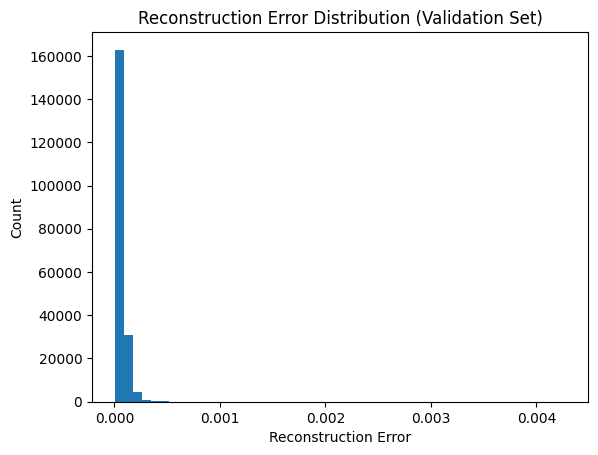

In [13]:
# Get reconstruction errors for each sample in the validation set
reconstruction_errors = []
model.eval()
with torch.no_grad():
    for features, _ in val_loader:
        features = features.to(device)
        output = model(features)
        errors = torch.mean((output - features) ** 2, dim=1).cpu().numpy()
        reconstruction_errors.extend(errors)

import matplotlib.pyplot as plt
plt.hist(reconstruction_errors, bins=50)
plt.title('Reconstruction Error Distribution (Validation Set)')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.show()

In [14]:
# Set threshold (e.g., 95th percentile of validation errors)

threshold = np.percentile(reconstruction_errors, 95)

# Get predictions on validation set
all_labels = []
all_preds = []
model.eval()
with torch.no_grad():
    for features, labels in val_loader:
        features = features.to(device)
        output = model(features)
        errors = torch.mean((output - features) ** 2, dim=1).cpu().numpy()
        preds = (errors > threshold).astype(int)
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.9455


### Saving the Model

In [15]:
torch.save(model.state_dict(), '../Model/saved_models/Trained_Model.pth')

In [ ]:
torch.save(model.state_dict(), '../Model/saved_models/Trained_Model.pkl')

In [17]:
torch.save(model.state_dict(), '../Model/saved_models/Trained_Model.h')